# Project 2

In [29]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from utils import generateDesignmatrix
from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline
#%matplotlib notebook

Calculating the coupeling coefficient J. 

Want to predict the energy with E = X*J

In [2]:
### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

"""
Comparing to project 1 - x = states, z = energies... 
Currently no y since we are in one dimension. 

"""

'\nComparing to project 1 - x = states, z = energies... \nCurrently no y since we are in one dimension. \n\n'

In [3]:
states.min(), states.max() #spin down, spin up

(-1, 1)

In [4]:
energies.min(), energies.max()

(-20.0, 20.0)

In [5]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2])) 
# build final data set
Data=[states,energies]

# define number of samples
n_samples=600
# define train and test data sets
X=Data[0][:n_samples]
Y=Data[1][:n_samples] 

Using the same amount of data as imput in order to compare with the notebook.


# Regression analysis - part b)

In [16]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X_train, Y_train, split_size=0.33333333
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
1


In [9]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [10]:
results["r2_test"]["lasso"]

[[0.40262349314656787,
  0.9999985545083317,
  0.9998558155572687,
  0.9855848114103795,
  0.07061504423701315,
  -0.018673830214775755,
  -0.018673830214775755,
  -0.018673830214775755,
  -0.018673830214775755,
  -0.018673830214775755]]

In [11]:
results["r2_test"]["ols"]

[[0.5617376490041183]]

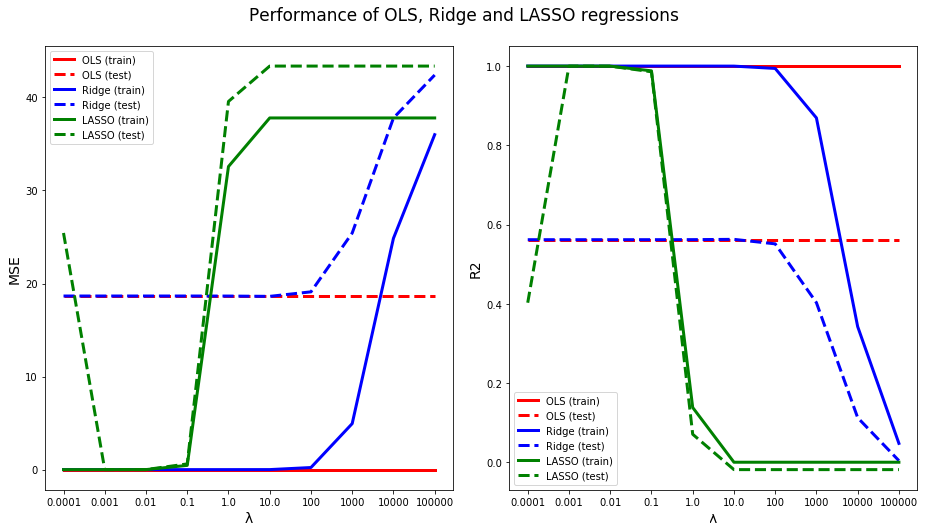

In [27]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

The same amount of trainingdata and testdata creates a almost similar plot Metha et al has the test line on 0.6 while we have it at 0.5617. Should be good enough.

# Plotting the coefficient of regression which is the coupling coefficient J

* Need to get olscoeff.reshape((40,40))
* Need to get the betas as output.

In [13]:
J_ols = coeffs["ols"][0][0].reshape((40,40))
J_ridge = np.array(coeffs["ridge"][0][1]).reshape((40,40))
J_lasso = coeffs["lasso"][0][1].reshape((40,40))

In [17]:
#np.shape(coeffs["ridge"])
lmbda = param_grid["ridge"]
#idx_lmd = 1
#J_ridge = coeffs["ridge"][0][idx_lmd].reshape((40,40))

## Results:

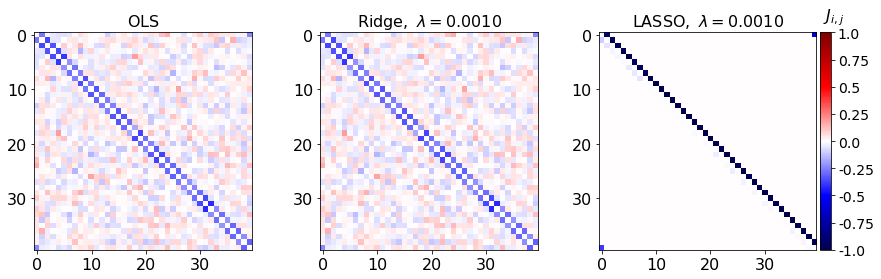

In [19]:
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')
#fig = plt.figure(figsize = (6,12))
fig, axarr = plt.subplots(nrows=1, ncols=3) #, figsize=(15,15)

axarr[0].imshow(J_ols,**cmap_args)
axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(J_ridge,**cmap_args)
axarr[1].set_title('$\\mathrm{Ridge}, \ \\lambda= %.4f$' %(lmbda[1]),fontsize=16) # %(lmbda)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(J_lasso,**cmap_args)
axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f $' %(lmbda[1]) ,fontsize=16) #%(lmbda)
axarr[2].tick_params(labelsize=16)

divider = make_axes_locatable(axarr[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im, cax=cax)

cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
fig.subplots_adjust(right=2.0)
fig.savefig("./results/figures/best_lambdas_one_dim.png", bbox_inches = "tight")

# Appendix: all lambdavalues

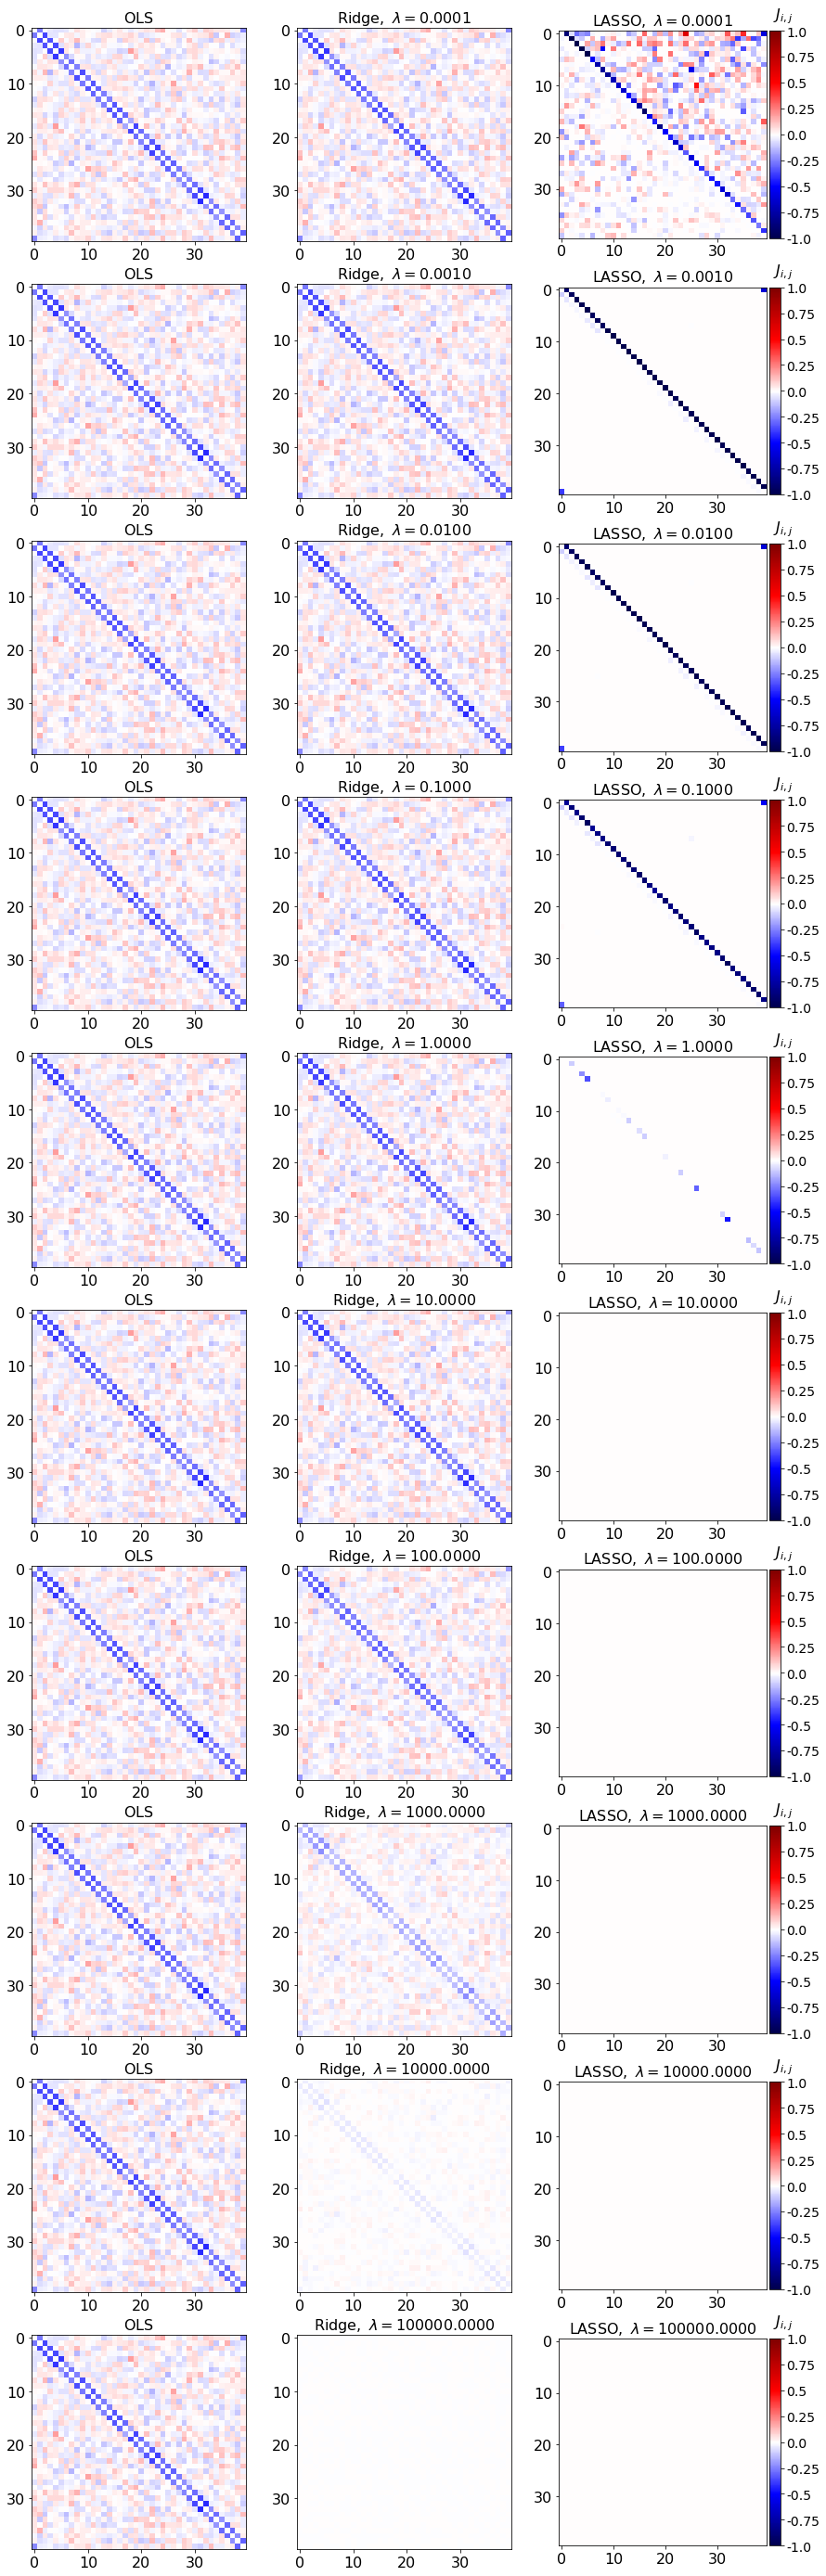

In [26]:
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')
counter = 0

fig, axarr = plt.subplots(nrows=len(lmbda), ncols=3, figsize = (6,50))
rownr = 0
for lmd in lmbda:
    
    J_ols = coeffs["ols"][0][0].reshape((40,40))
    J_ridge = np.array(coeffs["ridge"][0][counter]).reshape((40,40))
    J_lasso = coeffs["lasso"][0][counter].reshape((40,40))
    
    counter += 1
    
    axarr[rownr, 0].imshow(J_ols,**cmap_args)
    axarr[rownr, 0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[rownr, 0].tick_params(labelsize=16)

    axarr[rownr,1].imshow(J_ridge,**cmap_args)
    axarr[rownr,1].set_title('$\\mathrm{Ridge}, \ \\lambda= %.4f$' %(lmd),fontsize=16) # %(lmbda)
    axarr[rownr,1].tick_params(labelsize=16)

    im=axarr[rownr,2].imshow(J_lasso,**cmap_args)
    axarr[rownr,2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f $' %(lmd) ,fontsize=16) #%(lmbda)
    axarr[rownr,2].tick_params(labelsize=16)

    divider = make_axes_locatable(axarr[rownr,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)

    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    fig.subplots_adjust(right=2.0)
    rownr+=1
    
fig.savefig("./results/figures/all_lambdas_one_dim.png", bbox_inches = "tight")

# Bias and variance discussion 

In [36]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
}

lmd = {
    'ols': [0],
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, Y, nboots, split_size = 0.33333333)

ci_beta.shape

KeyboardInterrupt: 

In [39]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 1600)

In [32]:
bias

{'lasso': [], 'ols': 5.239941881781926e-08, 'ridge': []}

In [33]:
var # variance dominates because we don't have so mush data???

{'lasso': [], 'ols': 4.780630569602667e-06, 'ridge': []}

In [34]:
mse_test

{'lasso': [], 'ols': 4.8330299884204935e-06, 'ridge': []}

In [35]:
bias["ols"] + var["ols"] 

4.833029988420487e-06

The bias and variance summes to the mse of the ols model.